In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

,amount,fee,transfer_type_regular,stat_cr_canceled,stat_cr_direct_debit_rejected,stat_cr_direct_debit_sent,stat_cr_money_back,stat_cr_rejected,stat_cr_transaction_declined,stat_fe_cancelled,stat_fe_confirmed,stat_fe_cr_regular,stat_fe_rejected,recovery_status_completed,recovery_status_nice,recovery_status_pending,recovery_status_pending_direct_debit,category_nice,category_rejected_direct_debit
0,1.0,0.0,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False
1,100.0,0.0,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False


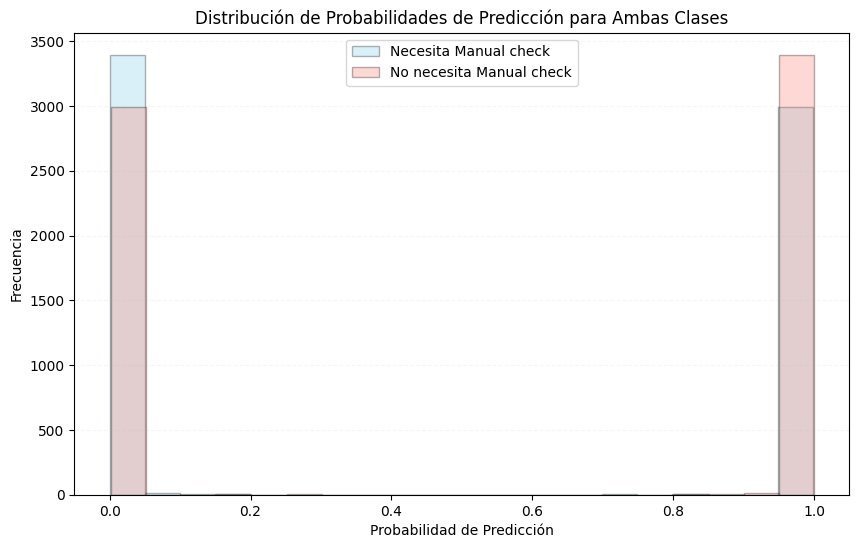

In [ ]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

# #a = df['transfer_type'].fillna('null').astype(str).unique(); print(sorted(a))
# df['transfer_type'] = df['transfer_type'].fillna('null').astype(str)
# #a = df['type'].fillna('null').astype(str).unique(); print(sorted(a))
# df['type'] = df['type'].fillna('null').astype(str)
# #df['type'] = df['type'].fillna('null').map({'incident': 3, 'instant_payment': 1, 'postpone': 4, '0' : 0})
# #df = df.drop(columns=['type'])

# Variables predictoras (ajusta según los datos disponibles)
columnas = ['amount','fee', 'transfer_type', 'stat_cr','stat_fe', 'recovery_status','category']
X = df[columnas].copy()
X = pd.get_dummies(X, columns=['transfer_type', 'stat_cr', 'stat_fe', 'recovery_status','category'], drop_first=True)
y = df['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo
display(X.head(2))
#df = df[columnas]
#X = df[columnas].copy()

feature_names = X.columns # Obtener los nombres de las características
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
expected_columns = X_train.columns

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()



In [23]:
# Asegurar que las fechas estén correctamente formateadas
df['created_at'] = pd.to_datetime(df['created_at'])
df['month_year'] = df['created_at'].dt.to_period('M')

# Calcular AUC por mes
monthly_performance = []
for period, group in df.groupby('month_year'):
    #if len(group) < 10:  # Ignorar meses con pocos datos
    #    continue
    
    X_period = group[['amount', 'transfer_type', 'stat_cr', 'recovery_status']]
    X_period = pd.get_dummies(
        group[['amount', 'transfer_type', 'stat_cr', 'recovery_status']],
        columns=['transfer_type', 'stat_cr', 'recovery_status'],
        drop_first=True
    ).reindex(columns=expected_columns, fill_value=0)

    y_period = group['needs_m_check_recov']
    
    # Realizar predicciones
    y_pred_prob = clf.predict_proba(X_period)[:, 1]
    
    # Calcular ROC y AUC
    fpr, tpr, _ = roc_curve(y_period, y_pred_prob)
    auc_score = auc(fpr, tpr)
    
    monthly_performance.append({'month_year': period, 'auc': auc_score})

# Convertir a DataFrame
monthly_performance_df = pd.DataFrame(monthly_performance)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- category_nice
- category_rejected_direct_debit
- fee
- stat_fe_cancelled
- stat_fe_confirmed
- ...


In [20]:
df = df_jo.copy()
# Crear una columna binaria para 'moderated_at'
df['moderated'] = df['moderated_at'].notnull().astype(int)

# Variables predictoras (ajusta según los datos disponibles)
X = df[['amount', 'transfer_type', 'stat_cr', 'recovery_status']].copy()

# Preprocesamiento: Convertir variables categóricas a dummies
X = pd.get_dummies(X, columns=['transfer_type', 'stat_cr', 'recovery_status'], drop_first=True)
display(X.head(2))
# Variable objetivo
y = df['moderated']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Guardar las columnas
expected_columns = X_train.columns
#display(expected_columns)

# Crear el modelo de regresión logística
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

,amount,transfer_type_regular,stat_cr_canceled,stat_cr_direct_debit_rejected,stat_cr_direct_debit_sent,stat_cr_money_back,stat_cr_rejected,stat_cr_transaction_declined,recovery_status_completed,recovery_status_nice,recovery_status_pending,recovery_status_pending_direct_debit
0,1.0,True,True,False,False,False,False,False,False,True,False,False
1,100.0,True,False,False,False,True,False,False,False,True,False,False


LogisticRegression(max_iter=1000, random_state=42)

In [37]:
# Asegurar que las fechas estén correctamente formateadas
df['created_at'] = pd.to_datetime(df['created_at'])
df['month_year'] = df['created_at'].dt.to_period('M')

# Calcular AUC por mes
monthly_performance = []
for period, group in df.groupby('month_year'):
    #if len(group) < 10:  # Ignorar meses con pocos datos
    #    continue
    
    X_period = group[['amount', 'transfer_type', 'stat_cr', 'recovery_status']]
    X_period = pd.get_dummies(
        group[['amount', 'transfer_type', 'stat_cr', 'recovery_status']],
        columns=['transfer_type', 'stat_cr', 'recovery_status'],
        drop_first=True
    ).reindex(columns=expected_columns, fill_value=0)

    y_period = group['moderated']
    
    # Realizar predicciones
    y_pred_prob = logreg.predict_proba(X_period)[:, 1]
    
    # Calcular ROC y AUC
    fpr, tpr, _ = roc_curve(y_period, y_pred_prob)
    auc_score = auc(fpr, tpr)
    
    monthly_performance.append({'month_year': period, 'auc': auc_score})

# Convertir a DataFrame
monthly_performance_df = pd.DataFrame(monthly_performance)


/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningle

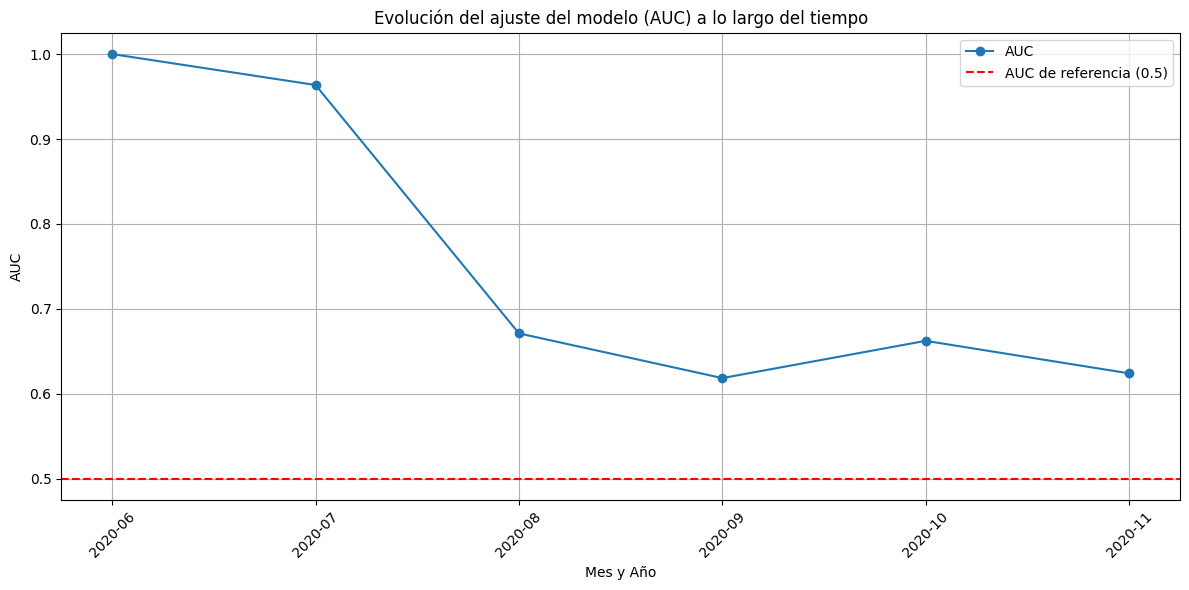

In [27]:
import matplotlib.pyplot as plt

# Graficar AUC a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(monthly_performance_df['month_year'].astype(str), monthly_performance_df['auc'], marker='o', label='AUC')
plt.axhline(0.5, color='red', linestyle='--', label='AUC de referencia (0.5)')
plt.title('Evolución del ajuste del modelo (AUC) a lo largo del tiempo')
plt.xlabel('Mes y Año')
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningle

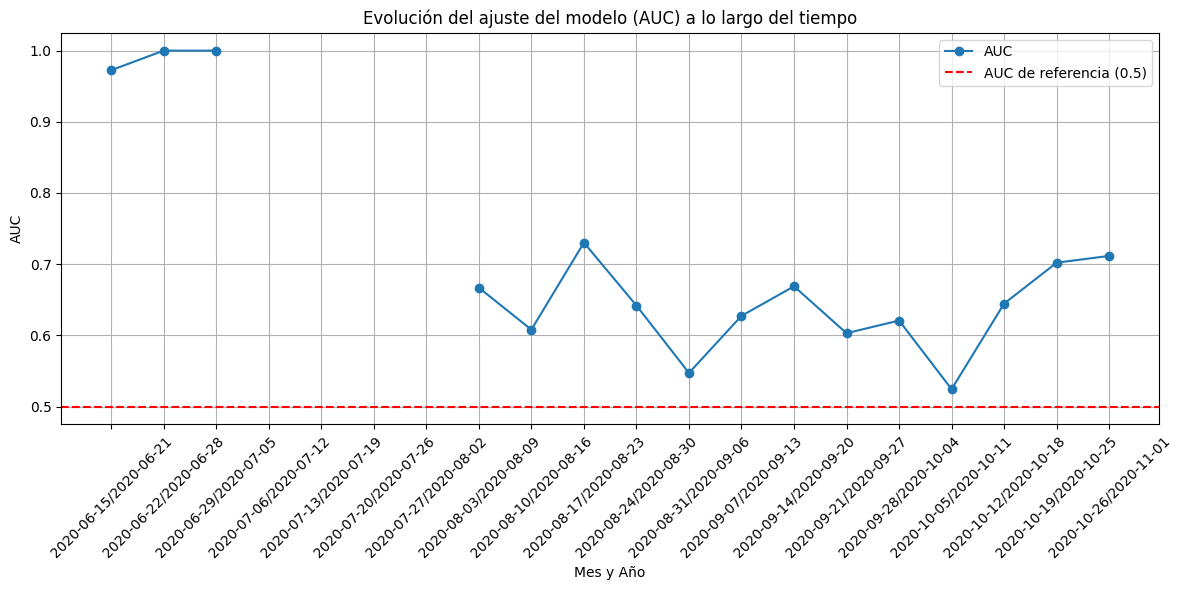

In [35]:
# Asegurar que las fechas estén correctamente formateadas
df['created_at'] = pd.to_datetime(df['created_at'])
df['month_year'] = df['created_at'].dt.to_period('W')

# Calcular AUC por mes
monthly_performance = []
for period, group in df.groupby('month_year'):
    #if len(group) < 10:  # Ignorar meses con pocos datos
    #    continue
    
    X_period = group[['amount', 'transfer_type', 'stat_cr', 'recovery_status']]
    X_period = pd.get_dummies(
        group[['amount', 'transfer_type', 'stat_cr', 'recovery_status']],
        columns=['transfer_type', 'stat_cr', 'recovery_status'],
        drop_first=True
    ).reindex(columns=expected_columns, fill_value=0)

    y_period = group['moderated']
    
    # Realizar predicciones
    y_pred_prob = logreg.predict_proba(X_period)[:, 1]
    
    # Calcular ROC y AUC
    fpr, tpr, _ = roc_curve(y_period, y_pred_prob)
    auc_score = auc(fpr, tpr)
    
    monthly_performance.append({'month_year': period, 'auc': auc_score})

# Convertir a DataFrame
monthly_performance_df = pd.DataFrame(monthly_performance)

# Graficar AUC a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(monthly_performance_df['month_year'].astype(str), monthly_performance_df['auc'], marker='o', label='AUC')
plt.axhline(0.5, color='red', linestyle='--', label='AUC de referencia (0.5)')
plt.title('Evolución del ajuste del modelo (AUC) a lo largo del tiempo')
plt.xlabel('Mes y Año')
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
